In [1]:
#Run this to troubleshoot some problem with the cairo library (happens in macos)
#Also, need to add to settings.json the following:
#"terminal.integrated.env.osx": {
#     "DYLD_LIBRARY_PATH": "/opt/homebrew/opt/cairo/lib:${env:DYLD_LIBRARY_PATH}"
# },

import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/cairo/lib:$DYLD_LIBRARY_PATH'


In [2]:
import sys
sys.path.append('/Users/evatakou/noise_est')
# from color_code_stim import *
from color_code_stim_copy import *
from noise_est_funcs_for_color_code import *
from utilities_for_color_code import *
from numerical_equations_for_color_code import *
from defects_matrix_construction import *
from construct_dem import *
import matplotlib.pyplot as plt 
import pymatching 
from pymatching import Matching 


In [ ]:
#W/ PARALLEL PROCESSING

from joblib import Parallel, delayed

def compare_logical_error_rate(d,p_circuit,num_shots_for_est,num_shots,num_rounds):

    
    obj        = ColorCode(d=d,rounds=num_rounds,p_circuit=p_circuit) ##p_cnot=0,p_bitflip=0.01, p_circuit=1e-2 ,
    circuit    = obj.circuit
 
    Z_dets,X_dets = get_Z_X_det_nodes(obj,num_rounds)
    Z_DEM,X_DEM   = decompose_org_DEM_into_ZX_DEMs(circuit,Z_dets,X_dets)

    dems_stim                     = {}

    for color in ["r", "g", "b"]: 
        # dem1,dem2        = obj.get_decomposed_dems(color)
        dem1,dem2= obj.decompose_detector_error_model([],color)
        dems_stim[color] = dem1, dem2  # stim.DetectorErrorModel


    #------- Estimation -------------------------------------
    defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS=get_defects(circuit,num_rounds,num_shots_for_est,obj)

    min_bound = 1e-12
    max_bound = 0.6 
    method    =  "least_squares" 

    vi_mean_Z      = avg_vi(defects_matrix_Z)
    vivj_mean_Z    = avg_vivj(defects_matrix_Z.data)
    p3_cnts_for_Z  = get_3_pnt_events_Z_DEM(defects_matrix_Z,obj,Z_DEM)
    detector_type  = "Z"
    vijk_for_Z     = get_vijk(p3_cnts_for_Z,num_rounds,vi_mean_Z,vivj_mean_Z,obj,detector_type)
    sols_for_Z     = solve_for_probs(min_bound,max_bound,method,vijk_for_Z)

    if len(defects_matrix_X)>0: #non-empty

        vi_mean_X      = avg_vi(defects_matrix_X)
        vivj_mean_X    = avg_vivj(defects_matrix_X.data)
        p3_cnts_for_X  = get_3_pnt_events_X_DEM(defects_matrix_X,obj,X_DEM,num_rounds)
        detector_type  = "X"
        vijk_for_X     = get_vijk(p3_cnts_for_X,num_rounds,vi_mean_X,vivj_mean_X,obj,detector_type)
        sols_for_X     = solve_for_probs(min_bound,max_bound,method,vijk_for_X)


    sols_for_defect_type           = sols_for_Z
    vi_mean                        = vi_mean_Z 
    vivj_mean                      = vivj_mean_Z 
    stims_DEM                      = Z_DEM 
    defects_type                   = "Z"
    pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)

    
    
    error_events_in_Z_DEM,my_Z_DEM = create_Z_DEM(pij_bd,pij_bulk,pij_time,p3,Z_DEM)

    if len(defects_matrix_X)>0:

        sols_for_defect_type           = sols_for_X
        vi_mean                        = vi_mean_X 
        vivj_mean                      = vivj_mean_X 
        stims_DEM                      = X_DEM 
        defects_type                   = "X"
        pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)
        error_events_in_X_DEM,my_X_DEM = create_X_DEM(pij_bd,pij_bulk,pij_time,p3,X_DEM)
    else:
        my_X_DEM={}

    r_only_DEM_mine,r_restricted_DEM_mine=create_lattices('r',my_Z_DEM,my_X_DEM,obj)
    b_only_DEM_mine,b_restricted_DEM_mine=create_lattices('b',my_Z_DEM,my_X_DEM,obj)
    g_only_DEM_mine,g_restricted_DEM_mine=create_lattices('g',my_Z_DEM,my_X_DEM,obj)

    dems_mine      = {}
    dems_mine['r'] = [r_restricted_DEM_mine,r_only_DEM_mine]
    dems_mine['b'] = [b_restricted_DEM_mine,b_only_DEM_mine]
    dems_mine['g'] = [g_restricted_DEM_mine,g_only_DEM_mine]

    #Find the detector coordinates and pass them to my dems

    for color in ['r','b','g']:

        for j in range(2):

            temp = dems_stim[color][j]
            
            for instruction in temp:
                if instruction.type=="error":
                    continue 
                else:
                    
                    dems_mine[color][j].append(instruction)

    det, obs  = obj.sample(num_shots)
    preds_obs = obj.decode(det, dems_stim, verbose=False)

    fails_stim = np.logical_xor(obs, preds_obs)
    preds_obs  = obj.decode(det, dems_mine, verbose=False)
    fails_mine = np.logical_xor(obs, preds_obs)


    stims_LE = sum(fails_stim)/num_shots
    my_LE    = sum(fails_mine)/num_shots

    return stims_LE,my_LE



def get_logical_error_rate_vs_QEC_rds(num_shots_for_est, num_shots, d, p, max_round, iterMax, n_jobs=-1):

    def run_one_round(rd,iterMax):
        print(f"Running rd: {rd} ...")
        all_LE_stim = []
        all_LE_mine = []
        for iter in range(iterMax):
            stims_LE, my_LE = compare_logical_error_rate(d, p, num_shots_for_est, num_shots, rd)
            all_LE_stim.append(stims_LE)
            all_LE_mine.append(my_LE)
        
        print(f"Done rd: {rd}")
        # return stims_LE, my_LE
        return np.mean(all_LE_stim), np.mean(all_LE_mine), np.std(all_LE_stim), np.std(all_LE_mine)

    results = Parallel(n_jobs=n_jobs)(
        delayed(run_one_round)(rd,iterMax) for rd in range(1, max_round + 1)
    )

    error_per_round_stim = [res[0] for res in results]
    error_per_round_mine = [res[1] for res in results]
    std_stim = [res[2] for res in results]
    std_mine = [res[3] for res in results]

    return error_per_round_stim, error_per_round_mine,std_stim,std_mine


num_shots_for_est  = 5*10**4
num_shots          = 5*10**5
d                  = 3
p                  = 0.001
max_round          = 3
iterMax            = 3
n_jobs             = 5
error_per_round_stim,error_per_round_mine, std_stim,std_mine = get_logical_error_rate_vs_QEC_rds(num_shots_for_est,num_shots,d,p,max_round,iterMax,n_jobs)



Running rd: 3 ...Running rd: 1 ...

Running rd: 2 ...


AttributeError: 'ColorCode' object has no attribute 'get_decomposed_dems'

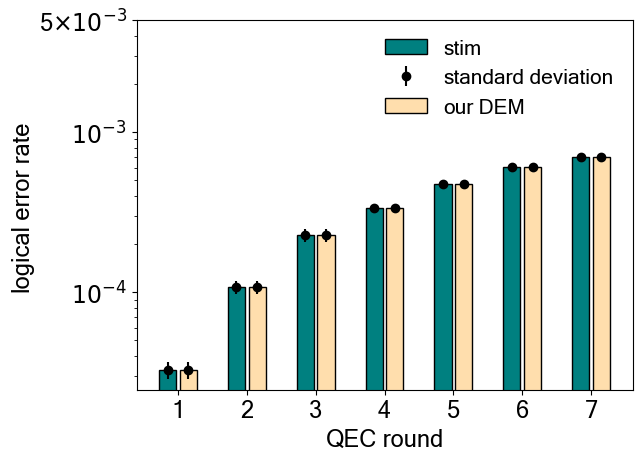

In [14]:
import matplotlib
fig, ax = plt.subplots()

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif" 

plt.bar(x=np.arange(1,max_round+1)-0.15,
        height=error_per_round_stim,width=0.25,edgecolor='black',
        facecolor='teal')

plt.errorbar(np.arange(1,max_round+1)-0.15, error_per_round_stim, std_stim, color="k", fmt="o")

plt.bar(x=np.arange(1,max_round+1)+0.15,
        height=error_per_round_mine,width=0.25,edgecolor='black',
        facecolor='navajowhite')

plt.errorbar(np.arange(1,max_round+1)+0.15, error_per_round_mine, std_mine, color="k", fmt="o")

plt.legend(["stim", "standard deviation","our DEM"],frameon=False,
                 shadow=True,
                 fontsize=15)
plt.xlabel("QEC round")
plt.ylabel("logical error rate")
plt.yscale('log')

plt.xticks(ticks=np.arange(1,max_round+1)) 
plt.yticks(ticks=[0.0001,0.001,0.005],labels=["$10^{-4}$","$10^{-3}$",r"5$\times 10^{-3}$"])

fig.savefig("d_7_r_7_error_0.001_N_5_10_5_(FOR_REVIEWS).pdf",bbox_inches='tight')

{'r': [4, 5, 8, 13, 14, 17],
 'g': [0, 1, 6, 9, 10, 15],
 'b': [2, 3, 7, 11, 12, 16]}

In [16]:
num_shots_for_est = 2*10**5
num_shots         = 5*10**4
d                 = 5
p_circuit         = 0.02
num_rounds        = 1




obj        = ColorCode(d=d,rounds=num_rounds,p_circuit=p_circuit) ##p_cnot=0,p_bitflip=0.01, p_circuit=1e-2 ,
circuit    = obj.circuit

Z_dets,X_dets = get_Z_X_det_nodes(obj,num_rounds)
Z_DEM,X_DEM   = decompose_org_DEM_into_ZX_DEMs(circuit,Z_dets,X_dets)

dems_stim                     = {}

for color in ["r", "g", "b"]: 
    
    # dem1,dem2        = obj.get_decomposed_dems(color)
    
    dem1,dem2= obj.decompose_detector_error_model([],color) #Will decompose the default dem from the circuit

    # dem1 = dems[0]
    # dem2 = dems[1]
    
    dems_stim[color] = dem1, dem2  # stim.DetectorErrorModel


#------- Estimation -------------------------------------
defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS=get_defects(circuit,num_rounds,num_shots_for_est,obj)

min_bound = 1e-12
max_bound = 0.6 
method    =  "least_squares" 

vi_mean_Z      = avg_vi(defects_matrix_Z)
vivj_mean_Z    = avg_vivj(defects_matrix_Z.data)
p3_cnts_for_Z  = get_3_pnt_events_Z_DEM(defects_matrix_Z,obj,Z_DEM)
detector_type  = "Z"
vijk_for_Z     = get_vijk(p3_cnts_for_Z,num_rounds,vi_mean_Z,vivj_mean_Z,obj,detector_type)
sols_for_Z     = solve_for_probs(min_bound,max_bound,method,vijk_for_Z)

if len(defects_matrix_X)>0: #non-empty

    vi_mean_X      = avg_vi(defects_matrix_X)
    vivj_mean_X    = avg_vivj(defects_matrix_X.data)
    p3_cnts_for_X  = get_3_pnt_events_X_DEM(defects_matrix_X,obj,X_DEM,num_rounds)
    detector_type  = "X"
    vijk_for_X     = get_vijk(p3_cnts_for_X,num_rounds,vi_mean_X,vivj_mean_X,obj,detector_type)
    sols_for_X     = solve_for_probs(min_bound,max_bound,method,vijk_for_X)


sols_for_defect_type           = sols_for_Z
vi_mean                        = vi_mean_Z 
vivj_mean                      = vivj_mean_Z 
stims_DEM                      = Z_DEM 
defects_type                   = "Z"
pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)



error_events_in_Z_DEM,my_Z_DEM = create_Z_DEM(pij_bd,pij_bulk,pij_time,p3,Z_DEM)

if len(defects_matrix_X)>0:

    sols_for_defect_type           = sols_for_X
    vi_mean                        = vi_mean_X 
    vivj_mean                      = vivj_mean_X 
    stims_DEM                      = X_DEM 
    defects_type                   = "X"
    pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)
    error_events_in_X_DEM,my_X_DEM = create_X_DEM(pij_bd,pij_bulk,pij_time,p3,X_DEM)
else:
    my_X_DEM={}

r_only_DEM_mine,r_restricted_DEM_mine=create_lattices('r',my_Z_DEM,my_X_DEM,obj)
b_only_DEM_mine,b_restricted_DEM_mine=create_lattices('b',my_Z_DEM,my_X_DEM,obj)
g_only_DEM_mine,g_restricted_DEM_mine=create_lattices('g',my_Z_DEM,my_X_DEM,obj)

dems_mine      = {}
dems_mine['r'] = [r_restricted_DEM_mine,r_only_DEM_mine]
dems_mine['b'] = [b_restricted_DEM_mine,b_only_DEM_mine]
dems_mine['g'] = [g_restricted_DEM_mine,g_only_DEM_mine]

#Find the detector coordinates and pass them to my dems

for color in ['r','b','g']:

    for j in range(2):

        temp = dems_stim[color][j]
        
        
        for instruction in temp:
            if instruction.type=="error":
                continue 
            else:
                
                dems_mine[color][j].append(instruction)

det, obs  = obj.sample(num_shots)
preds_obs = obj.decode(det, dems_stim, verbose=False)

fails_stim = np.logical_xor(obs, preds_obs)


preds_obs_new  = obj.decode(det, dems_mine, verbose=False)
fails_mine = np.logical_xor(obs, preds_obs_new)


stims_LE = sum(fails_stim)/num_shots
my_LE    = sum(fails_mine)/num_shots


print("stim:",stims_LE)
print("mine:",my_LE)




stim: 0.19418
mine: 0.19458


In [12]:
dems_mine['r']

[stim.DetectorErrorModel('''
     error(0.0613614) D0 D2 L0
     error(0.084144) D0 D3 L1
     error(0.0550062) D0 D12 L2
     error(0.0119475) D0 D6 L3
     error(0.0925376) D0 D9 L4
     error(0.0606845) D1 D3 L5
     error(0.128831) D1 L6
     error(0.0931719) D1 D10 L7
     error(0.108509) D2 L8
     error(0.0779502) D2 D9 L9
     error(0.012172) D2 D7 L10
     error(0.0915179) D2 D11 L11
     error(0.00971416) D2 D15 L12
     error(0.019185) D3 L13
     error(0.0834557) D3 D6 L14
     error(0.0795231) D3 D10 L15
     error(0.0848058) D3 D12 L16
     error(0.0593779) D6 D7 L17
     error(0.03347) D6 D12 L18
     error(0.120601) D7 L19
     error(0.0647139) D7 D15 L20
     error(0.137694) D9 D12 L21
     error(0.108982) D12 D15 L22
     error(0.133925) D15 L23
     error(0.117168) D6 L24
     error(0.138039) D10 L25
     error(0.079597) D6 D15 L26
     error(0.0937356) D7 D16 L27
     error(0.100275) D9 D11 L28
     error(0.010927) D9 D15 L29
     error(0.104344) D10 D12 L30
     er

In [13]:
obj.dems_decomposed['r']

{'r': [stim.DetectorErrorModel('''
      error(0.0613614) D0 D2 L0
      error(0.084144) D0 D3 L1
      error(0.0550062) D0 D12 L2
      error(0.0119475) D0 D6 L3
      error(0.0925376) D0 D9 L4
      error(0.0606845) D1 D3 L5
      error(0.128831) D1 L6
      error(0.0931719) D1 D10 L7
      error(0.108509) D2 L8
      error(0.0779502) D2 D9 L9
      error(0.012172) D2 D7 L10
      error(0.0915179) D2 D11 L11
      error(0.00971416) D2 D15 L12
      error(0.019185) D3 L13
      error(0.0834557) D3 D6 L14
      error(0.0795231) D3 D10 L15
      error(0.0848058) D3 D12 L16
      error(0.0593779) D6 D7 L17
      error(0.03347) D6 D12 L18
      error(0.120601) D7 L19
      error(0.0647139) D7 D15 L20
      error(0.137694) D9 D12 L21
      error(0.108982) D12 D15 L22
      error(0.133925) D15 L23
      error(0.117168) D6 L24
      error(0.138039) D10 L25
      error(0.079597) D6 D15 L26
      error(0.0937356) D7 D16 L27
      error(0.100275) D9 D11 L28
      error(0.010927) D9 D15 L29
    

TypeError: ColorCode.decompose_detector_error_model() missing 2 required positional arguments: 'ORG_DEM' and 'color'

In [66]:
obj.dems_decomposed['r']

<DemDecomp object with color='r', Hs[0].shape=(18, 35), Hs[1].shape=(53, 85)>

In [62]:
dems_stim['r'][0]

stim.DetectorErrorModel('''
    error(0.0610563) D0 D2
    error(0.0841545) D0 D3
    error(0.0511058) D0 D12
    error(0.0106667) D6 D0
    error(0.0930258) D0 D9
    error(0.0610563) D1 D3
    error(0.126768) D1
    error(0.0930258) D10 D1
    error(0.105979) D2
    error(0.0792883) D2 D9
    error(0.0106667) D7 D2
    error(0.0930258) D11 D2
    error(0.0106667) D15 D2
    error(0.0237156) D3
    error(0.0840934) D6 D3
    error(0.0792883) D10 D3
    error(0.0795848) D12 D3
    error(0.0610563) D6 D7
    error(0.0313222) D6 D12
    error(0.11643) D7
    error(0.0700543) D15 D7
    error(0.134677) D12 D9
    error(0.114385) D15 D12
    error(0.130662) D15
    error(0.118577) D6
    error(0.142471) D10
    error(0.0795848) D15 D6
    error(0.0930258) D16 D7
    error(0.101708) D11 D9
    error(0.0106667) D15 D9
    error(0.101708) D10 D12
    error(0.142523) D11
    error(0.0106667) D12
    error(0.101708) D15 D16
    error(0.142523) D16
    detector(8, 0, 0, 2, 1) D0
    detector(20,

In [61]:
obj.dems_decomposed['r'][0]

stim.DetectorErrorModel('''
    error(0.0610563) D0 D2
    error(0.0841545) D0 D3
    error(0.0511058) D0 D12
    error(0.0106667) D6 D0
    error(0.0930258) D0 D9
    error(0.0610563) D1 D3
    error(0.126768) D1
    error(0.0930258) D10 D1
    error(0.105979) D2
    error(0.0792883) D2 D9
    error(0.0106667) D7 D2
    error(0.0930258) D11 D2
    error(0.0106667) D15 D2
    error(0.0237156) D3
    error(0.0840934) D6 D3
    error(0.0792883) D10 D3
    error(0.0795848) D12 D3
    error(0.0610563) D6 D7
    error(0.0313222) D6 D12
    error(0.11643) D7
    error(0.0700543) D15 D7
    error(0.134677) D12 D9
    error(0.114385) D15 D12
    error(0.130662) D15
    error(0.118577) D6
    error(0.142471) D10
    error(0.0795848) D15 D6
    error(0.0930258) D16 D7
    error(0.101708) D11 D9
    error(0.0106667) D15 D9
    error(0.101708) D10 D12
    error(0.142523) D11
    error(0.0106667) D12
    error(0.101708) D15 D16
    error(0.142523) D16
    detector(8, 0, 0, 2, 1) D0
    detector(20,

In [51]:
dems_mine['r']

[stim.DetectorErrorModel('''
     error(0.0631541) D0 D2 L0
     error(0.0818157) D0 D3 L1
     error(0.0501378) D0 D12 L2
     error(0.0129219) D0 D6 L3
     error(0.093826) D0 D9 L4
     error(0.0586038) D1 D3 L5
     error(0.126709) D1 L6
     error(0.092536) D1 D10 L7
     error(0.103084) D2 L8
     error(0.0810718) D2 D9 L9
     error(0.0149607) D2 D7 L10
     error(0.0962363) D2 D11 L11
     error(0.00785216) D2 D15 L12
     error(0.0227162) D3 L13
     error(0.0876465) D3 D6 L14
     error(0.0802921) D3 D10 L15
     error(0.0774426) D3 D12 L16
     error(0.056774) D6 D7 L17
     error(0.035255) D6 D12 L18
     error(0.115102) D7 L19
     error(0.0682168) D7 D15 L20
     error(0.131954) D9 D12 L21
     error(0.109379) D12 D15 L22
     error(0.131307) D15 L23
     error(0.116449) D6 L24
     error(0.146618) D10 L25
     error(0.0831763) D6 D15 L26
     error(0.094799) D7 D16 L27
     error(0.100997) D9 D11 L28
     error(0.0116399) D9 D15 L29
     error(0.0992936) D10 D12 L30
    

In [50]:
obj.get_decomposed_dems('r')

(stim.DetectorErrorModel('''
     error(0.0610563) D0 D2
     error(0.0841545) D0 D3
     error(0.0511058) D0 D12
     error(0.0106667) D6 D0
     error(0.0930258) D0 D9
     error(0.0610563) D1 D3
     error(0.126768) D1
     error(0.0930258) D10 D1
     error(0.105979) D2
     error(0.0792883) D2 D9
     error(0.0106667) D7 D2
     error(0.0930258) D11 D2
     error(0.0106667) D15 D2
     error(0.0237156) D3
     error(0.0840934) D6 D3
     error(0.0792883) D10 D3
     error(0.0795848) D12 D3
     error(0.0610563) D6 D7
     error(0.0313222) D6 D12
     error(0.11643) D7
     error(0.0700543) D15 D7
     error(0.134677) D12 D9
     error(0.114385) D15 D12
     error(0.130662) D15
     error(0.118577) D6
     error(0.142471) D10
     error(0.0795848) D15 D6
     error(0.0930258) D16 D7
     error(0.101708) D11 D9
     error(0.0106667) D15 D9
     error(0.101708) D10 D12
     error(0.142523) D11
     error(0.0106667) D12
     error(0.101708) D15 D16
     error(0.142523) D16
     detect

In [41]:
dems_mine['r'][0]

stim.DetectorErrorModel('''
    error(0.0597562) D0 D2 L0
    error(0.0859863) D0 D3 L1
    error(0.0519229) D0 D12 L2
    error(0.00973768) D0 D6 L3
    error(0.09373) D0 D9 L4
    error(0.0609755) D1 D3 L5
    error(0.125299) D1 L6
    error(0.0952129) D1 D10 L7
    error(0.103392) D2 L8
    error(0.0796923) D2 D9 L9
    error(0.0127021) D2 D7 L10
    error(0.0928361) D2 D11 L11
    error(0.0106625) D2 D15 L12
    error(0.0237615) D3 L13
    error(0.085477) D3 D6 L14
    error(0.0792799) D3 D10 L15
    error(0.0773689) D3 D12 L16
    error(0.0626376) D6 D7 L17
    error(0.0312718) D6 D12 L18
    error(0.115252) D7 L19
    error(0.0653906) D7 D15 L20
    error(0.134311) D9 D12 L21
    error(0.105817) D12 D15 L22
    error(0.14226) D15 L23
    error(0.121767) D6 L24
    error(0.143944) D10 L25
    error(0.0825911) D6 D15 L26
    error(0.0960757) D7 D16 L27
    error(0.100857) D9 D11 L28
    error(0.0132718) D9 D15 L29
    error(0.102327) D10 D12 L30
    error(0.143445) D11 L31
    erro

In [40]:
dems_stim['r'][0]

stim.DetectorErrorModel('''
    error(0.0610563) D0 D2
    error(0.0841545) D0 D3
    error(0.0511058) D0 D12
    error(0.0106667) D6 D0
    error(0.0930258) D0 D9
    error(0.0610563) D1 D3
    error(0.126768) D1
    error(0.0930258) D10 D1
    error(0.105979) D2
    error(0.0792883) D2 D9
    error(0.0106667) D7 D2
    error(0.0930258) D11 D2
    error(0.0106667) D15 D2
    error(0.0237156) D3
    error(0.0840934) D6 D3
    error(0.0792883) D10 D3
    error(0.0795848) D12 D3
    error(0.0610563) D6 D7
    error(0.0313222) D6 D12
    error(0.11643) D7
    error(0.0700543) D15 D7
    error(0.134677) D12 D9
    error(0.114385) D15 D12
    error(0.130662) D15
    error(0.118577) D6
    error(0.142471) D10
    error(0.0795848) D15 D6
    error(0.0930258) D16 D7
    error(0.101708) D11 D9
    error(0.0106667) D15 D9
    error(0.101708) D10 D12
    error(0.142523) D11
    error(0.0106667) D12
    error(0.101708) D15 D16
    error(0.142523) D16
    detector(8, 0, 0, 2, 1) D0
    detector(20,

In [37]:
my_Z_DEM

stim.DetectorErrorModel('''
    error(0.0382858) D0 D2 D4
    error(0.0231425) D0 D2 L0
    error(0.0263857) D0 D3 D4
    error(0.0607308) D0 D3 L0
    error(0.0227634) D0 D4 D12
    error(0.0090859) D0 D6
    error(0.0908619) D0 D9
    error(0.0123207) D0 D12 D14
    error(0.0203503) D0 D12 L0
    error(0.0376425) D1 D3 D5
    error(0.0261538) D1 D3 L0
    error(0.0497177) D1 D5
    error(0.0924818) D1 D10
    error(0.0852736) D1 L0
    error(0.0236786) D2 D4
    error(0.0163183) D2 D4 D9
    error(0.0120933) D2 D7
    error(0.0127932) D2 D9 D13
    error(0.0533663) D2 D9 L0
    error(0.0944024) D2 D11
    error(0.0316195) D2 D13
    error(0.00159946) D2 D13 D15
    error(0.0669353) D2 L0
    error(0.0166854) D3
    error(0.0369076) D3 D4 D6
    error(0.0270844) D3 D5 D6
    error(0.0151641) D3 D5 D10
    error(0.0264357) D3 D6 D14
    error(0.0156784) D3 D10 D14
    error(0.0548928) D3 D10 L0
    error(0.0819454) D3 D12
    error(0.0241673) D4 D6 D7
    error(0.0165404) D4 D6 D12
   

In [15]:
error_per_round_stim

[3.266666666666666e-05,
 0.00010799999999999998,
 0.000226,
 0.000336,
 0.00047466666666666664,
 0.0006046666666666667,
 0.0006966666666666666]

In [16]:
error_per_round_mine

[3.266666666666666e-05,
 0.00010799999999999998,
 0.000226,
 0.000336,
 0.00047466666666666664,
 0.0006046666666666667,
 0.0006966666666666666]